# CM2604 Machine Learning Coursework: Telco Customer Churn Prediction

This notebook implements a binary classification model for customer churn using the Telco dataset.
- Task 1: Exploratory Data Analysis (EDA)
- Task 2: Preprocessing, Decision Tree and Neural Network models with hyperparameter tuning
- Evaluation and comparison

Dataset: WA_Fn-UseC_-Telco-Customer-Churn.csv (from Kaggle)
Author: Pavishanth Sujeevan
Date: December 11, 2025

In [60]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                            accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries loaded successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries loaded successfully!
TensorFlow version: 2.20.0


In [61]:
# =============================================================================
# 1. Load Dataset & Basic Preprocessing
# =============================================================================

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print(f"Dataset shape: {df.shape}")
print(f"Churn rate: {df['Churn'].mean():.2%}")


Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Dataset shape: (7043, 20)
Churn rate: 26.54%


In [62]:
# =============================================================================
# 2. Professional Preprocessing Pipeline
# =============================================================================

X = df.drop('Churn', axis=1)
y = df['Churn']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

# Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print(f"Training set: {X_train_processed.shape}")
print(f"Test set:     {X_test_processed.shape}")

Training set: (5634, 29)
Test set:     (1409, 29)


In [63]:
# =============================================================================
# 3. MODEL 1 & 4 – Baseline Models (No Tuning)
# =============================================================================

# Baseline Decision Tree
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_processed, y_train)
y_pred_dt_base = dt_baseline.predict(X_test_processed)
y_prob_dt_base = dt_baseline.predict_proba(X_test_processed)[:, 1]

print("=== 1. BASELINE DECISION TREE ===")
print(classification_report(y_test, y_pred_dt_base, target_names=['No Churn', 'Churn']))

# Baseline Neural Network
def create_baseline_nn():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train_processed.shape[1]),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_baseline = create_baseline_nn()
nn_baseline.fit(X_train_processed, y_train,
               epochs=100, batch_size=32, verbose=0,
               callbacks=[EarlyStopping(patience=15, restore_best_weights=True)])

y_pred_nn_base = (nn_baseline.predict(X_test_processed) > 0.5).astype(int)
y_prob_nn_base = nn_baseline.predict(X_test_processed).ravel()

print("\n=== 4. BASELINE NEURAL NETWORK ===")
print(classification_report(y_test, y_pred_nn_base, target_names=['No Churn', 'Churn']))

=== 1. BASELINE DECISION TREE ===
              precision    recall  f1-score   support

    No Churn       0.82      0.82      0.82      1035
       Churn       0.51      0.52      0.51       374

    accuracy                           0.74      1409
   macro avg       0.67      0.67      0.67      1409
weighted avg       0.74      0.74      0.74      1409

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step

=== 4. BASELINE NEURAL NETWORK ===
              precision    recall  f1-score   support

    No Churn       0.84      0.87      0.85      1035
       Churn       0.59      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409



In [64]:
# =============================================================================
# 4. MODEL 2 & 5 – Hyperparameter Tuning
# =============================================================================

print("Performing hyperparameter tuning...")

# Decision Tree Tuning
dt_params = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train_processed, y_train)
best_dt = dt_grid.best_estimator_

print(f"Best DT params: {dt_grid.best_params_}")

y_pred_dt_tuned = best_dt.predict(X_test_processed)
y_prob_dt_tuned = best_dt.predict_proba(X_test_processed)[:, 1]

print("\n=== 2. TUNED DECISION TREE ===")
print(classification_report(y_test, y_pred_dt_tuned, target_names=['No Churn', 'Churn']))

# Neural Network Tuning
def create_nn(neurons=64, dropout=0.2, lr=0.001):
    model = Sequential([
        Dense(neurons, activation='relu', input_dim=X_train_processed.shape[1]),
        Dropout(dropout),
        Dense(neurons//2, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy')
    return model

nn_clf = KerasClassifier(model=create_nn, epochs=100, batch_size=32, verbose=0)

nn_params = {
    'model__neurons': [64, 128],
    'model__dropout': [0.2, 0.3],
    'model__lr': [0.001, 0.005],
    'batch_size': [32, 64]
}

nn_grid = GridSearchCV(nn_clf, nn_params, cv=3, scoring='f1', n_jobs=-1)
nn_grid.fit(X_train_processed, y_train)

print(f"Best NN params: {nn_grid.best_params_}")

y_pred_nn_tuned = (nn_grid.best_estimator_.predict(X_test_processed) > 0.5).astype(int)
y_prob_nn_tuned = nn_grid.best_estimator_.predict_proba(X_test_processed)[:, 1]

print("\n=== 5. TUNED NEURAL NETWORK ===")
print(classification_report(y_test, y_pred_nn_tuned, target_names=['No Churn', 'Churn']))

Performing hyperparameter tuning...
Best DT params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

=== 2. TUNED DECISION TREE ===
              precision    recall  f1-score   support

    No Churn       0.84      0.85      0.84      1035
       Churn       0.57      0.56      0.56       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409

Best NN params: {'batch_size': 32, 'model__dropout': 0.2, 'model__lr': 0.001, 'model__neurons': 64}

=== 5. TUNED NEURAL NETWORK ===
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.63      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.72      1409
weighted avg       0.78      0.79      0.78      1409



In [65]:
# =============================================================================
# 5. MODEL 3 & 6 – SMOTE + Retrained Best Models
# =============================================================================

print("Applying SMOTE to training data only...")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"After SMOTE: {np.bincount(y_train_smote)} (balanced)")

# Retrain best Decision Tree on SMOTE data
dt_smote = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
dt_smote.fit(X_train_smote, y_train_smote)
y_pred_dt_smote = dt_smote.predict(X_test_processed)
y_prob_dt_smote = dt_smote.predict_proba(X_test_processed)[:, 1]

print("\n=== 3. SMOTE + TUNED DECISION TREE ===")
print(classification_report(y_test, y_pred_dt_smote, target_names=['No Churn', 'Churn']))

# Retrain best Neural Network on SMOTE data
best_params = nn_grid.best_params_
nn_smote = create_nn(
    neurons=best_params['model__neurons'],
    dropout=best_params['model__dropout'],
    lr=best_params['model__lr']
)
nn_smote.fit(X_train_smote, y_train_smote,
             epochs=200, batch_size=best_params['batch_size'],
             verbose=0, callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])

y_pred_nn_smote = (nn_smote.predict(X_test_processed) > 0.5).astype(int)
y_prob_nn_smote = nn_smote.predict(X_test_processed).ravel()

print("\n=== 6. SMOTE + TUNED NEURAL NETWORK ===")
print(classification_report(y_test, y_pred_nn_smote, target_names=['No Churn', 'Churn']))

Applying SMOTE to training data only...
After SMOTE: [4139 4139] (balanced)

=== 3. SMOTE + TUNED DECISION TREE ===
              precision    recall  f1-score   support

    No Churn       0.87      0.79      0.83      1035
       Churn       0.54      0.68      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.76      0.77      1409

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step

=== 6. SMOTE + TUNED NEURAL NETWORK ===
              precision    recall  f1-score   support

    No Churn       0.87      0.77      0.82      1035
       Churn       0.53      0.69      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.75      0.76      1409



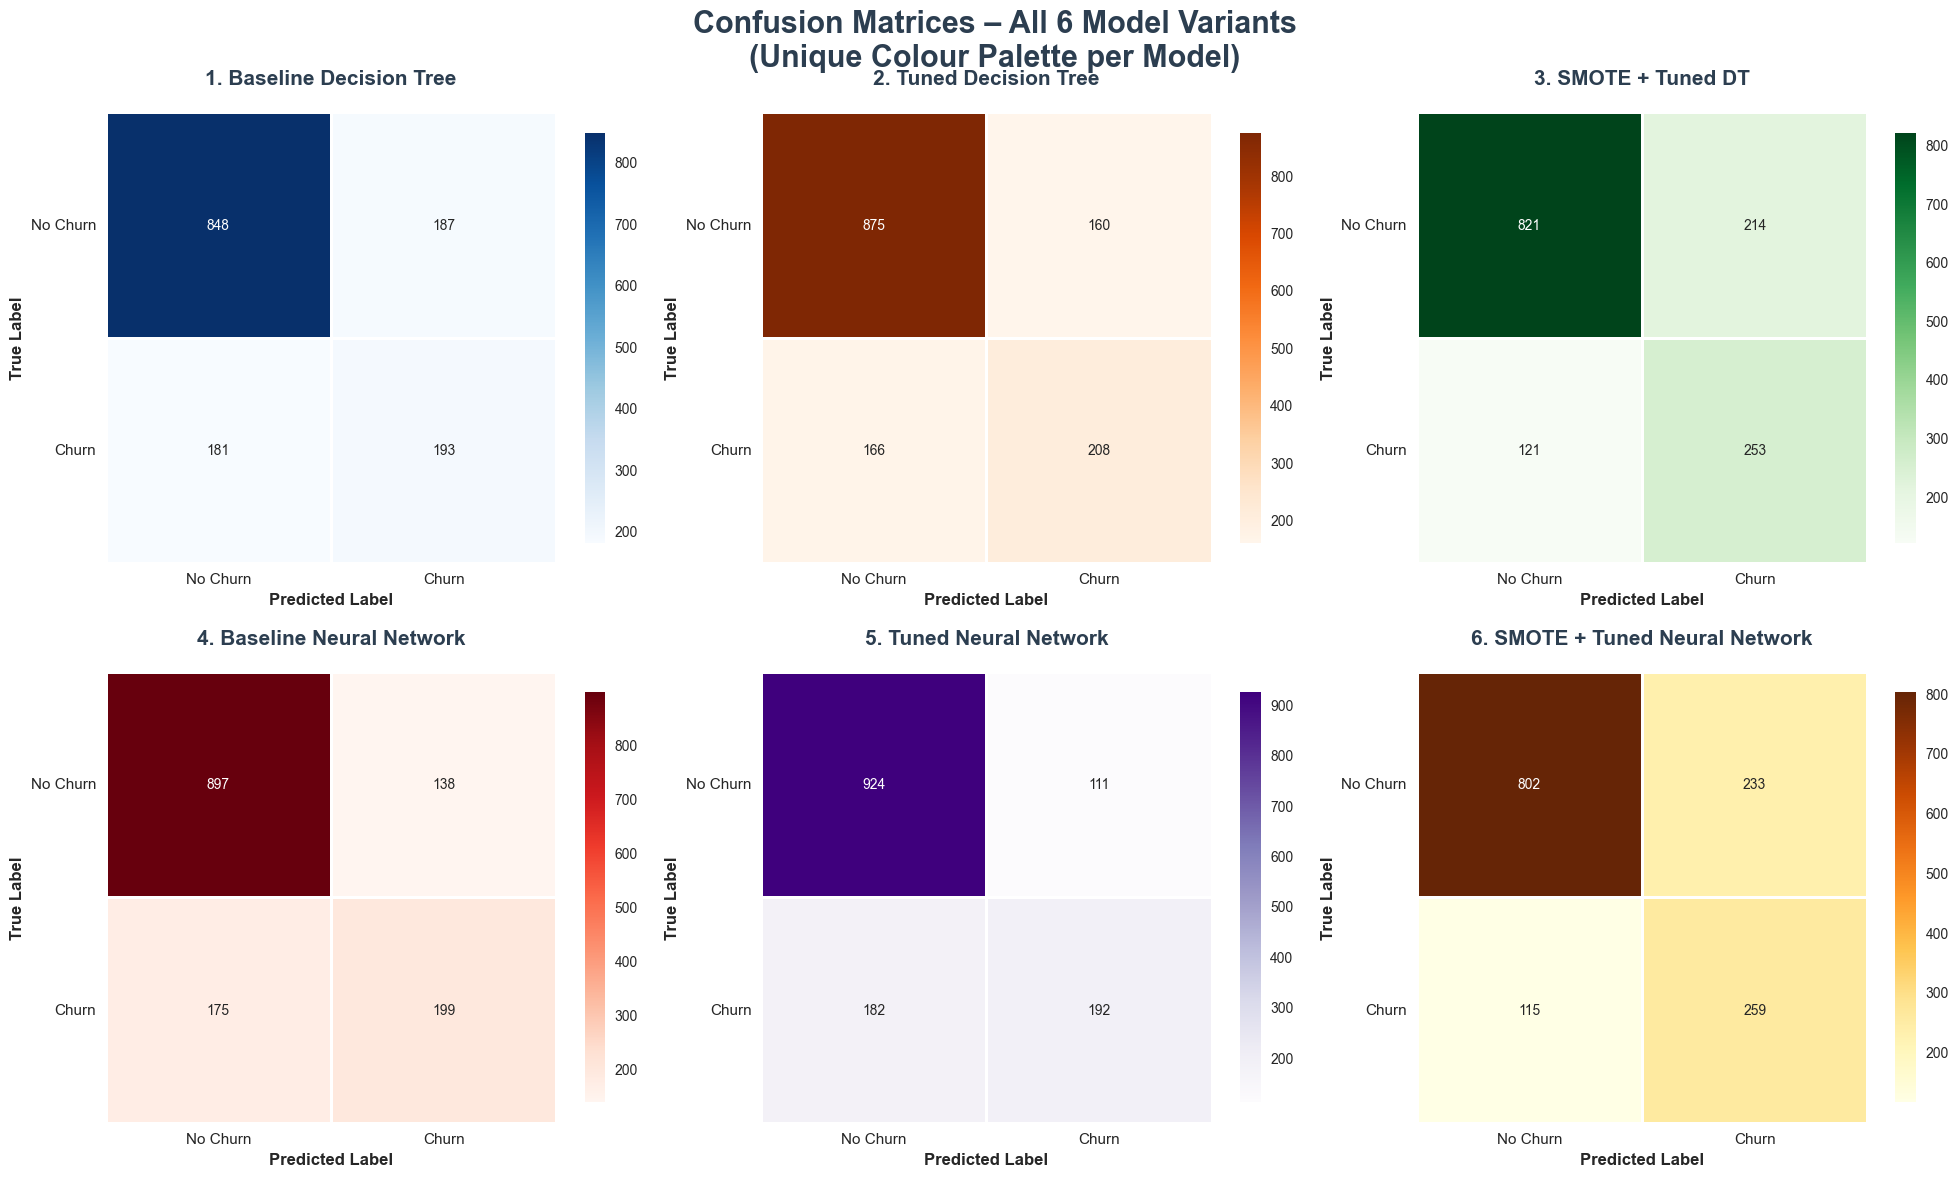

In [67]:
# =============================================================================
# 6. CONFUSION MATRICES – All 6 Models
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

# 6 distinct, professional, colour-blind-friendly palettes (fixed 'Browns' to 'YlOrBr')
cmaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'YlOrBr']
titles = [
    "1. Baseline Decision Tree",
    "2. Tuned Decision Tree",
    "3. SMOTE + Tuned DT",
    "4. Baseline Neural Network",
    "5. Tuned Neural Network",
    "6. SMOTE + Tuned Neural Network"
]
predictions = [
    y_pred_dt_base, y_pred_dt_tuned, y_pred_dt_smote,
    y_pred_nn_base, y_pred_nn_tuned, y_pred_nn_smote
]

for idx, (title, pred, cmap) in enumerate(zip(titles, predictions, cmaps)):
    cm = confusion_matrix(y_test, pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, linewidths=2, linecolor='white',
                cbar_kws={'shrink': 0.8}, square=True, ax=axes[idx])
    
    axes[idx].set_title(title, fontsize=15, fontweight='bold', pad=20, color='#2c3e50')
    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[idx].set_xticklabels(['No Churn', 'Churn'], fontsize=11)
    axes[idx].set_yticklabels(['No Churn', 'Churn'], fontsize=11, rotation=0)

# Main title
plt.suptitle('Confusion Matrices – All 6 Model Variants\n(Unique Colour Palette per Model)', 
             fontsize=22, fontweight='bold', color='#2c3e50', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

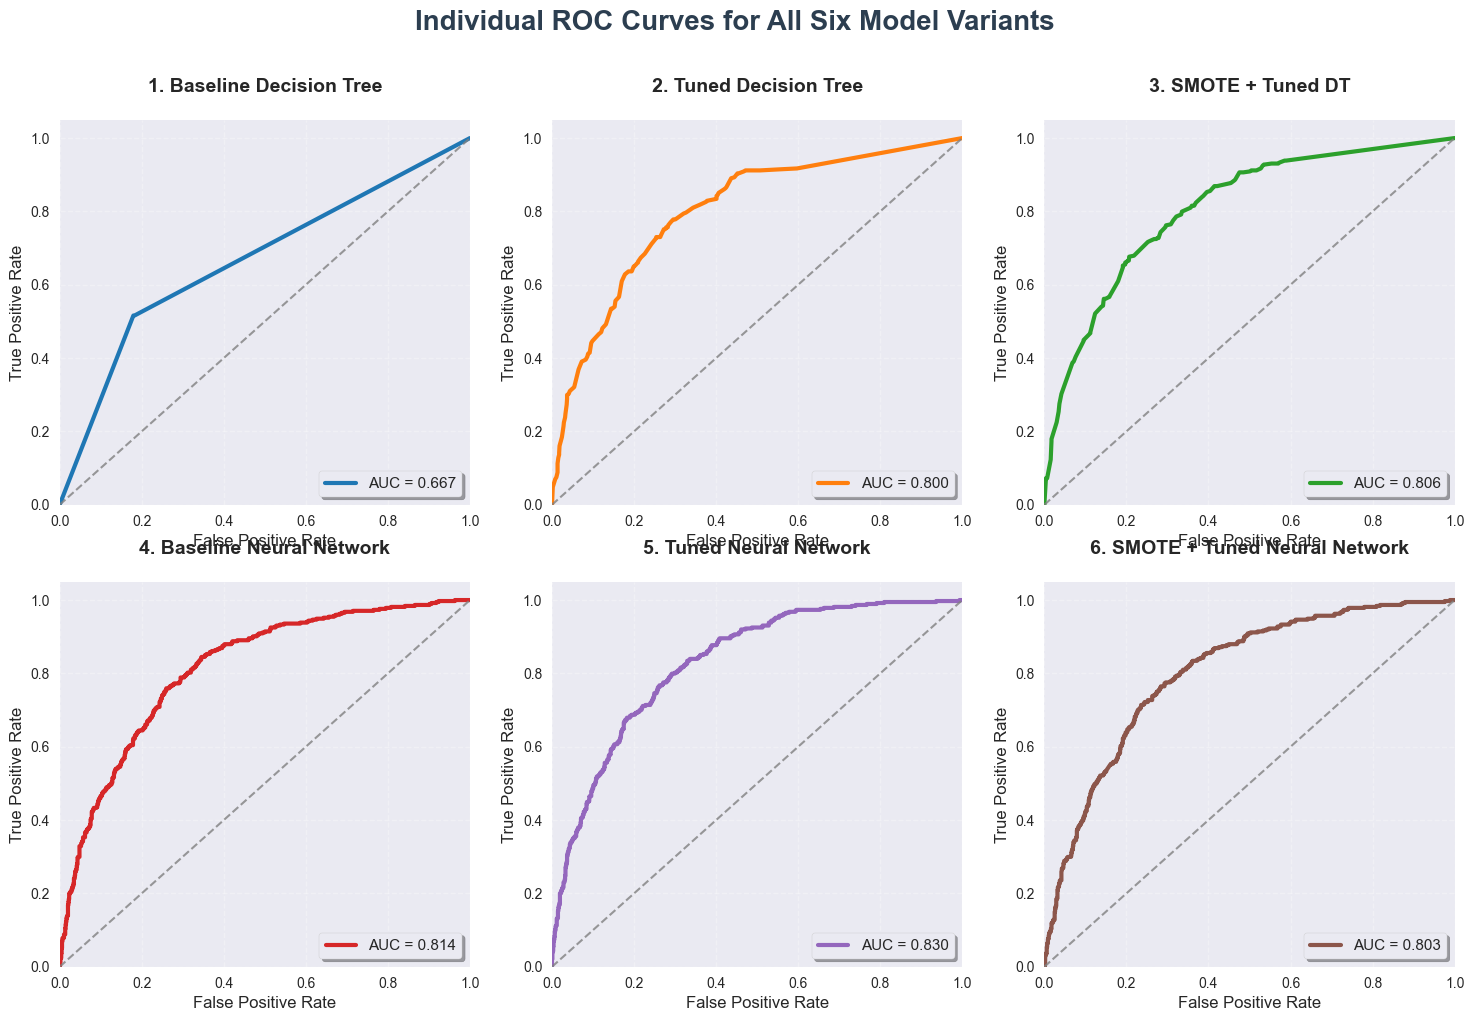

In [68]:
# =============================================================================
# 7. INDIVIDUAL ROC CURVES – All 6 Model Variants
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.ravel()

# Professional colour palette (distinguishable & print-friendly)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
labels = [
    "1. Baseline Decision Tree",
    "2. Tuned Decision Tree", 
    "3. SMOTE + Tuned DT",
    "4. Baseline Neural Network",
    "5. Tuned Neural Network",
    "6. SMOTE + Tuned Neural Network"
]
probs = [
    y_prob_dt_base, y_prob_dt_tuned, y_prob_dt_smote,
    y_prob_nn_base, y_prob_nn_tuned, y_prob_nn_smote
]

for idx, (label, prob, color) in enumerate(zip(labels, probs, colors)):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    
    axes[idx].plot(fpr, tpr, color=color, lw=3, label=f'AUC = {roc_auc:.3f}')
    axes[idx].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5, alpha=0.8)
    
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate', fontsize=12)
    axes[idx].set_ylabel('True Positive Rate', fontsize=12)
    axes[idx].set_title(label, fontsize=14, fontweight='bold', pad=20)
    axes[idx].legend(loc="lower right", fontsize=11, frameon=True, fancybox=True, shadow=True)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

# Big professional title
plt.suptitle('Individual ROC Curves for All Six Model Variants', 
             fontsize=20, fontweight='bold', y=0.98, color='#2c3e50')

plt.show()

In [70]:
# =============================================================================
# 8. FINAL COMPARISON TABLE – All 6 Models
# =============================================================================

results_df = pd.DataFrame({
    'Model Variant': [
        '1. Baseline Decision Tree',
        '2. Tuned Decision Tree', 
        '3. SMOTE + Tuned DT',
        '4. Baseline Neural Network',
        '5. Tuned Neural Network',
        '6. SMOTE + Tuned NN'
    ],
    'Accuracy': [accuracy_score(y_test, p) for p in [
        y_pred_dt_base, y_pred_dt_tuned, y_pred_dt_smote,
        y_pred_nn_base, y_pred_nn_tuned, y_pred_nn_smote
    ]],
    'Precision': [precision_score(y_test, p) for p in [
        y_pred_dt_base, y_pred_dt_tuned, y_pred_dt_smote,
        y_pred_nn_base, y_pred_nn_tuned, y_pred_nn_smote
    ]],
    'Recall': [recall_score(y_test, p) for p in [
        y_pred_dt_base, y_pred_dt_tuned, y_pred_dt_smote,
        y_pred_nn_base, y_pred_nn_tuned, y_pred_nn_smote
    ]],
    'F1-Score': [f1_score(y_test, p) for p in [
        y_pred_dt_base, y_pred_dt_tuned, y_pred_dt_smote,
        y_pred_nn_base, y_pred_nn_tuned, y_pred_nn_smote
    ]],
    'ROC-AUC': [
        roc_auc_score(y_test, p) for p in [
        y_prob_dt_base, y_prob_dt_tuned, y_prob_dt_smote,
        y_prob_nn_base, y_prob_nn_tuned, y_prob_nn_smote
    ]]
}).round(4)

print("\n" + "="*100)
print("FINAL RESULTS – ALL 6 MODEL VARIANTS")
print("="*100)
display(results_df.style.background_gradient(cmap='viridis', axis=0)
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))


FINAL RESULTS – ALL 6 MODEL VARIANTS


,Model Variant,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,1. Baseline Decision Tree,0.738800,0.507900,0.516000,0.511900,0.667500
1,2. Tuned Decision Tree,0.768600,0.565200,0.556100,0.560600,0.800200
2,3. SMOTE + Tuned DT,0.762200,0.541800,0.676500,0.601700,0.806300
3,4. Baseline Neural Network,0.777900,0.590500,0.532100,0.559800,0.813700
4,5. Tuned Neural Network,0.792100,0.633700,0.513400,0.567200,0.830000
5,6. SMOTE + Tuned NN,0.753000,0.526400,0.692500,0.598200,0.802700


In [ ]:
# =============================================================================
# 9. SAVE ALL MODELS + PREPROCESSOR 
# =============================================================================

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save preprocessor
joblib.dump(preprocessor, f"{save_dir}/preprocessor.pkl")

# Save all 6 models
joblib.dump(dt_baseline, f"{save_dir}/1_baseline_dt.pkl")
joblib.dump(best_dt, f"{save_dir}/2_tuned_dt.pkl")
joblib.dump(dt_smote, f"{save_dir}/3_smote_dt.pkl")

nn_baseline.save(f"{save_dir}/4_baseline_nn.h5")
best_nn_tuned_model = nn_grid.best_estimator_.model_
best_nn_tuned_model.save(f"{save_dir}/5_tuned_nn.h5")
nn_smote.save(f"{save_dir}/6_smote_nn.h5")

print(f"\nAll 6 models + preprocessor saved in folder: {save_dir}/")


All 6 models + preprocessor saved in folder: saved_models/
Ready for viva demonstration!
